In [ ]:
# Create a new environment for Mesmer before the first run. DeepCell/Mesmer works with Python 3.8+ and we are using 3.8.20 and 3.9
# Activate the environment and install necessary packages: pip install deepcell
import os
import tifffile
import time
import psutil
import numpy as np
import cv2
import math
from deepcell.applications import Mesmer
from deepcell_toolbox.utils import tile_image, untile_image
from pathlib import Path
from PIL import Image
from numpy.lib.stride_tricks import as_strided
from skimage.segmentation import flood_fill
import matplotlib.pyplot as plt

# Load DeepCell API token securely - get key from deepcell website, create account with institution email address
os.environ.update({"DEEPCELL_ACCESS_TOKEN": "irTp24VK.sf2kGZEml3jFJVEwyDiqDXqHID81sHAQ"}) #Please change to your own DeepCell API token here

# Load Mesmer segmentation model
# Load Mesmer segmentation model
app = Mesmer()

# Functions:
def normalize_channel(channel):
    """Normalize an image channel to the range [0,1]."""
    return (channel - channel.min()) / (channel.max() - channel.min())

def apply_gamma_correction(image, gamma):
    """Apply Gamma Correction to an image."""
    gammacorrected_image = (np.power(normalize_channel(image), (1 / gamma)) * 65535).astype(np.uint16) 
    return gammacorrected_image

def apply_unsharp_mask(image, sigma, strength):
    """Apply Unsharp Masking to an image and ensure type consistency."""
    img_float32 = image.astype(np.float32)  # Convert to float32
    blurred = cv2.GaussianBlur(img_float32, (0, 0), sigma)
    sharpened = cv2.addWeighted(img_float32, 1 + strength, blurred, -strength, 0, dtype=cv2.CV_32F)   
    unsharpmasking_image = np.clip(sharpened, 0, 65535).astype(np.uint16) # Clip values to valid range and convert back to uint16
    return unsharpmasking_image

def mesmer_masking(image):
    mask = app.predict(image, image_mpp=0.650, compartment='nuclear')
    return mask

def tile(image, tile_size, overlap):
    B, X, Y, C = image.shape
    tile_x, tile_y = tile_size
    overlap_x, overlap_y = overlap

    step_x = tile_x - overlap_x
    step_y = tile_y - overlap_y

    num_tiles_x = int(np.ceil((X - tile_x) // step_x)) + 1
    num_tiles_y = int(np.ceil((Y - tile_y) // step_y)) + 1

    stride_b, stride_x, stride_y, stride_c = image.strides
    new_shape = (B, num_tiles_x, num_tiles_y, tile_x, tile_y, C)
    new_strides = (stride_b, step_x * stride_x, step_y * stride_y, stride_x, stride_y, stride_c)

    return as_strided(image, shape=new_shape, strides=new_strides)

def untile(tiles, original_shape, tile_size, overlap):
    tiles = tiles.copy()
    B, X, Y, C = original_shape
    tile_x, tile_y = tile_size
    overlap_x, overlap_y = overlap

    step_x = tile_x - overlap_x
    step_y = tile_y - overlap_y

    untiled = np.zeros((B, X, Y, C), dtype=tiles.dtype)

    num_tiles_x, num_tiles_y = tiles.shape[1:3]

    for i in range(num_tiles_x):
        x_start = i * step_x
        x_end = x_start + tile_x

        untiled_row = np.zeros((B, tile_x, Y, C), dtype=tiles.dtype)

        for j in range(num_tiles_y):
            y_start = j * step_y
            y_end = y_start + tile_y

            if j > 0:
                color_map = {}
                for k in range(tile_x):
                    current_value = untiled_row[0, k, y_start + overlap_y // 2, 0]
                    new_value = tiles[0, i, j, k, overlap_y // 2, 0]
                    color_map[current_value] = color_map.get(current_value, {})
                    color_map[current_value][new_value] = (k, color_map[current_value].get(new_value, (k, 0))[1] + 1)
                color_map[0] = {}
                for current_value in color_map:
                    if 0 in color_map[current_value]:
                        del color_map[current_value][0]
                    if len(color_map[current_value]) > 0:
                        new_value = max(color_map[current_value], key=lambda x: color_map[current_value][x][1])
                        k = color_map[current_value][new_value][0]
                        flood_fill(tiles[0, i, j, :, :, 0], (k, overlap_y // 2), current_value, in_place=True)
                untiled_row[:, :, y_start+overlap_y // 2:y_end, :] = tiles[:, i, j, :, overlap_y // 2:, :]
            else:
                untiled_row[:, :, y_start:y_end, :] = tiles[:, i, j, :, :, :]
            tiles[tiles != 0] += untiled_row.max()

        if i > 0:
            color_map = {}
            for k in range(Y):
                current_value = untiled[0, x_start + overlap_x // 2, k, 0]
                new_value = untiled_row[0, overlap_x // 2, k, 0]
                color_map[current_value] = color_map.get(current_value, {})
                color_map[current_value][new_value] = (k, color_map[current_value].get(new_value, (k, 0))[1] + 1)
            color_map[0] = {}
            for current_value in color_map:
                if 0 in color_map[current_value]:
                    del color_map[current_value][0]
                if len(color_map[current_value]) > 0:
                    new_value = max(color_map[current_value], key=lambda x: color_map[current_value][x][1])
                    k = color_map[current_value][new_value][0]
                    flood_fill(untiled_row[0, :, :, 0], (overlap_x // 2, k), current_value, in_place=True)
            untiled[:, x_start+overlap_x // 2:x_end, :, :] = untiled_row[:, overlap_x // 2:, :, :]
        else:
            untiled[:, x_start:x_end, :, :] = untiled_row

    return untiled

# GMM on Tile Mean Intensities and automatically filter out background clusters
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

def filter_tiles_by_mean_intensity_gmm_auto_background(image_tiles, channel_idx=0, n_components=3, visualize=True):
    """
    Apply GMM clustering on mean intensity of tiles, then filter out background clusters.

    Args:
        image_tiles: np.ndarray of shape (1, H_tiles, W_tiles, H, W, C)
        channel_idx: index of the channel to compute the mean on (e.g., DAPI)
        n_components: number of GMM clusters to fit
        background_clusters: list of cluster indices considered background
        visualize: whether to plot the results

    Returns:
        skipped_mask: boolean mask of tiles to skip (True = background)
        cluster_labels: GMM cluster label for each tile
    """
    _, H_tiles, W_tiles, H, W, C = image_tiles.shape

    tile_means = []
    tile_coords = []

    for i in range(H_tiles):
        for j in range(W_tiles):
            tile = image_tiles[0, i, j, :, :, channel_idx]
            tile_mean = np.mean(tile)
            tile_means.append([tile_mean])  # keep it 2D for GMM
            tile_coords.append((i, j))

    tile_means = np.array(tile_means)

    # Apply GMM
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(tile_means)
    labels = gmm.predict(tile_means)
    original_labels = labels.copy()

    # Rank cluster indices by ascending mean
    cluster_means = [tile_means[original_labels == i].mean() for i in range(n_components)]
    ranked_clusters = np.argsort(cluster_means)  # ranked by mean intensity
    background_cluster = ranked_clusters[0]  # lowest-mean cluster

    # Create skipped mask and filter our background tiles
    skipped_mask = np.zeros((H_tiles, W_tiles), dtype=bool)
    for idx, (i, j) in enumerate(tile_coords):
        if original_labels[idx] == background_cluster:
            skipped_mask[i, j] = True

    if visualize:
        plt.figure(figsize=(8, 4))
        plt.hist(tile_means[:, 0], bins=50, color='gray', alpha=0.4, label='Mean Intensity')
        for i in range(n_components):
            mean = gmm.means_[i][0]
            plt.axvline(mean, color=f"C{i}", linestyle='--', label=f'Cluster {i} (mean: {mean:.1f})')
        plt.axvline(cluster_means[background_cluster], color='red', linestyle='-', label='Selected BG cluster')
        plt.xlabel("Mean Tile Intensity")
        plt.ylabel("Count")
        plt.title("Tile Mean Intensities with GMM Clusters")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return skipped_mask, original_labels, ranked_clusters

def print_memory_usage(msg=""):
    process = psutil.Process(os.getpid())
    mem_mb = process.memory_info().rss / (1024 ** 2)
    print(f"[{msg}] Memory usage: {mem_mb:.2f} MB")

2025-07-25 16:36:48.295437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/elruuska/.conda/envs/mesmer/lib/python3.9/site-packages/cv2/../../lib64:
2025-07-25 16:36:48.295453: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO:root:Checking for cached data
INFO:root:Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
INFO:root:MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
INFO:root:Extracting /home/elruuska/.deepcell/models/MultiplexSegmentation-9.tar.gz
INFO:root:Successfully extracted /home/elruuska/.deepcell/models/MultiplexSegmentation-9.tar.gz into /home/elruuska/.deepcell/models
2025-07-25 16:36:51.735308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

In [2]:
#Define Input & Output Folders
input_folder = "/run/user/1325827/gvfs/smb-share:server=group3.ad.helsinki.fi,share=h30492/farkkilab2/9_EyeMT/9_EyeMT_Cycif/batch2_adjacent_slides/tif/" # Change it to the path of your own input folder
output_folder = "/run/user/1325827/gvfs/smb-share:server=group3.ad.helsinki.fi,share=h30492/farkkilab2/9_EyeMT/9_EyeMT_Cycif/batch2_adjacent_slides/mesmer_seg_new" # Change it to the path of your own output folder
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

# List all TIFF images in input folder
image_files = ["S188_iOme.ome.tif"]
print(f"Found {len(image_files)} images.")

# Define Parameters
gamma = 1.5
sigma = 1.0
strength = 1.5
channel = [0, 5] # Channel for Masking - Mesmer needs two channels, we tested with two DAPI channel, but the  ideal according to deepcell website would be a nuclear and a cytoplasm channel

# Define Parameters if tiling of image is necessary
tile_size = 2500, 2500

Found 1 images.


In [3]:
import gc

[➡️ Start of loop] Memory usage: 1169.07 MB
[Before loading image] Memory usage: 1169.07 MB
[After loading image] Memory usage: 10291.88 MB
[After gamma correction] Memory usage: 19357.46 MB
[After unsharp masking] Memory usage: 28423.19 MB
[After deleting corrected data] Memory usage: 19358.85 MB
[After stacking channels] Memory usage: 28423.19 MB
[After deleting sharpened data] Memory usage: 19358.84 MB
[After expand_dims] Memory usage: 19358.84 MB
[After deleting original image] Memory usage: 10294.50 MB
(1324, 1283)
(1, 29, 54, 2500, 2500, 2)
Tile (0, 0) Mean Intensity: 350.55291424
Tile (0, 1) Mean Intensity: 346.48404304
Tile (0, 2) Mean Intensity: 341.9774984
Tile (0, 3) Mean Intensity: 346.3702632
Tile (0, 4) Mean Intensity: 348.33564992
Tile (0, 5) Mean Intensity: 348.09958432
Tile (0, 6) Mean Intensity: 348.06668736
Tile (0, 7) Mean Intensity: 346.364832
Tile (0, 8) Mean Intensity: 344.08095648
Tile (0, 9) Mean Intensity: 347.38720976
Tile (0, 10) Mean Intensity: 351.37773152

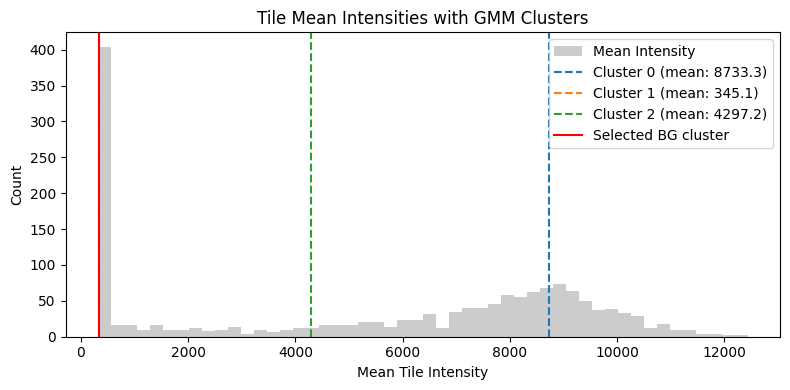

INFO:root:Converting image dtype to float


Tile (0, 32) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (0, 33) Processing Time: 7.42 seconds


INFO:root:Converting image dtype to float


Tile (0, 34) Processing Time: 7.58 seconds


INFO:root:Converting image dtype to float


Tile (0, 35) Processing Time: 7.65 seconds


INFO:root:Converting image dtype to float


Tile (0, 36) Processing Time: 7.41 seconds


INFO:root:Converting image dtype to float


Tile (0, 37) Processing Time: 7.45 seconds


INFO:root:Converting image dtype to float


Tile (0, 38) Processing Time: 7.57 seconds


INFO:root:Converting image dtype to float


Tile (1, 30) Processing Time: 7.44 seconds


INFO:root:Converting image dtype to float


Tile (1, 31) Processing Time: 7.57 seconds


INFO:root:Converting image dtype to float


Tile (1, 32) Processing Time: 7.62 seconds


INFO:root:Converting image dtype to float


Tile (1, 33) Processing Time: 7.85 seconds


INFO:root:Converting image dtype to float


Tile (1, 34) Processing Time: 8.40 seconds


INFO:root:Converting image dtype to float


Tile (1, 35) Processing Time: 8.18 seconds


INFO:root:Converting image dtype to float


Tile (1, 36) Processing Time: 8.00 seconds


INFO:root:Converting image dtype to float


Tile (1, 37) Processing Time: 7.75 seconds


INFO:root:Converting image dtype to float


Tile (1, 38) Processing Time: 7.71 seconds


INFO:root:Converting image dtype to float


Tile (2, 29) Processing Time: 7.54 seconds


INFO:root:Converting image dtype to float


Tile (2, 30) Processing Time: 7.56 seconds


INFO:root:Converting image dtype to float


Tile (2, 31) Processing Time: 7.82 seconds


INFO:root:Converting image dtype to float


Tile (2, 32) Processing Time: 7.97 seconds


INFO:root:Converting image dtype to float


Tile (2, 33) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (2, 34) Processing Time: 8.40 seconds


INFO:root:Converting image dtype to float


Tile (2, 35) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (2, 36) Processing Time: 8.67 seconds


INFO:root:Converting image dtype to float


Tile (2, 37) Processing Time: 8.14 seconds


INFO:root:Converting image dtype to float


Tile (2, 38) Processing Time: 7.64 seconds


INFO:root:Converting image dtype to float


Tile (2, 39) Processing Time: 7.50 seconds


INFO:root:Converting image dtype to float


Tile (2, 40) Processing Time: 7.56 seconds


INFO:root:Converting image dtype to float


Tile (2, 41) Processing Time: 7.69 seconds


INFO:root:Converting image dtype to float


Tile (2, 42) Processing Time: 7.59 seconds


INFO:root:Converting image dtype to float


Tile (2, 43) Processing Time: 7.63 seconds


INFO:root:Converting image dtype to float


Tile (2, 44) Processing Time: 7.67 seconds


INFO:root:Converting image dtype to float


Tile (2, 45) Processing Time: 7.71 seconds


INFO:root:Converting image dtype to float


Tile (2, 46) Processing Time: 7.49 seconds


INFO:root:Converting image dtype to float


Tile (3, 28) Processing Time: 7.46 seconds


INFO:root:Converting image dtype to float


Tile (3, 29) Processing Time: 7.43 seconds


INFO:root:Converting image dtype to float


Tile (3, 30) Processing Time: 7.88 seconds


INFO:root:Converting image dtype to float


Tile (3, 31) Processing Time: 8.01 seconds


INFO:root:Converting image dtype to float


Tile (3, 32) Processing Time: 8.18 seconds


INFO:root:Converting image dtype to float


Tile (3, 33) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (3, 34) Processing Time: 8.58 seconds


INFO:root:Converting image dtype to float


Tile (3, 35) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (3, 36) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (3, 37) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (3, 38) Processing Time: 8.43 seconds


INFO:root:Converting image dtype to float


Tile (3, 39) Processing Time: 7.86 seconds


INFO:root:Converting image dtype to float


Tile (3, 40) Processing Time: 7.83 seconds


INFO:root:Converting image dtype to float


Tile (3, 41) Processing Time: 7.76 seconds


INFO:root:Converting image dtype to float


Tile (3, 42) Processing Time: 7.87 seconds


INFO:root:Converting image dtype to float


Tile (3, 43) Processing Time: 8.05 seconds


INFO:root:Converting image dtype to float


Tile (3, 44) Processing Time: 7.70 seconds


INFO:root:Converting image dtype to float


Tile (3, 45) Processing Time: 7.73 seconds


INFO:root:Converting image dtype to float


Tile (3, 46) Processing Time: 7.61 seconds


INFO:root:Converting image dtype to float


Tile (3, 47) Processing Time: 7.54 seconds


INFO:root:Converting image dtype to float


Tile (3, 48) Processing Time: 7.49 seconds


INFO:root:Converting image dtype to float


Tile (3, 49) Processing Time: 7.40 seconds


INFO:root:Converting image dtype to float


Tile (4, 20) Processing Time: 7.35 seconds


INFO:root:Converting image dtype to float


Tile (4, 21) Processing Time: 7.34 seconds


INFO:root:Converting image dtype to float


Tile (4, 25) Processing Time: 7.46 seconds


INFO:root:Converting image dtype to float


Tile (4, 26) Processing Time: 7.64 seconds


INFO:root:Converting image dtype to float


Tile (4, 27) Processing Time: 7.45 seconds


INFO:root:Converting image dtype to float


Tile (4, 28) Processing Time: 7.41 seconds


INFO:root:Converting image dtype to float


Tile (4, 29) Processing Time: 7.57 seconds


INFO:root:Converting image dtype to float


Tile (4, 30) Processing Time: 8.21 seconds


INFO:root:Converting image dtype to float


Tile (4, 31) Processing Time: 8.39 seconds


INFO:root:Converting image dtype to float


Tile (4, 32) Processing Time: 8.28 seconds


INFO:root:Converting image dtype to float


Tile (4, 33) Processing Time: 8.47 seconds


INFO:root:Converting image dtype to float


Tile (4, 34) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (4, 35) Processing Time: 8.97 seconds


INFO:root:Converting image dtype to float


Tile (4, 36) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (4, 37) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (4, 38) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (4, 39) Processing Time: 8.61 seconds


INFO:root:Converting image dtype to float


Tile (4, 40) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (4, 41) Processing Time: 8.41 seconds


INFO:root:Converting image dtype to float


Tile (4, 42) Processing Time: 8.03 seconds


INFO:root:Converting image dtype to float


Tile (4, 43) Processing Time: 8.09 seconds


INFO:root:Converting image dtype to float


Tile (4, 44) Processing Time: 8.08 seconds


INFO:root:Converting image dtype to float


Tile (4, 45) Processing Time: 8.04 seconds


INFO:root:Converting image dtype to float


Tile (4, 46) Processing Time: 7.96 seconds


INFO:root:Converting image dtype to float


Tile (4, 47) Processing Time: 8.03 seconds


INFO:root:Converting image dtype to float


Tile (4, 48) Processing Time: 7.85 seconds


INFO:root:Converting image dtype to float


Tile (4, 49) Processing Time: 7.77 seconds


INFO:root:Converting image dtype to float


Tile (4, 50) Processing Time: 7.62 seconds


INFO:root:Converting image dtype to float


Tile (4, 51) Processing Time: 7.42 seconds


INFO:root:Converting image dtype to float


Tile (4, 52) Processing Time: 7.44 seconds


INFO:root:Converting image dtype to float


Tile (5, 12) Processing Time: 7.56 seconds


INFO:root:Converting image dtype to float


Tile (5, 13) Processing Time: 7.38 seconds


INFO:root:Converting image dtype to float


Tile (5, 14) Processing Time: 7.51 seconds


INFO:root:Converting image dtype to float


Tile (5, 15) Processing Time: 7.57 seconds


INFO:root:Converting image dtype to float


Tile (5, 16) Processing Time: 7.49 seconds


INFO:root:Converting image dtype to float


Tile (5, 17) Processing Time: 7.51 seconds


INFO:root:Converting image dtype to float


Tile (5, 18) Processing Time: 7.45 seconds


INFO:root:Converting image dtype to float


Tile (5, 19) Processing Time: 7.33 seconds


INFO:root:Converting image dtype to float


Tile (5, 20) Processing Time: 7.55 seconds


INFO:root:Converting image dtype to float


Tile (5, 21) Processing Time: 7.56 seconds


INFO:root:Converting image dtype to float


Tile (5, 22) Processing Time: 7.63 seconds


INFO:root:Converting image dtype to float


Tile (5, 23) Processing Time: 7.48 seconds


INFO:root:Converting image dtype to float


Tile (5, 24) Processing Time: 7.43 seconds


INFO:root:Converting image dtype to float


Tile (5, 25) Processing Time: 7.58 seconds


INFO:root:Converting image dtype to float


Tile (5, 26) Processing Time: 7.91 seconds


INFO:root:Converting image dtype to float


Tile (5, 27) Processing Time: 7.86 seconds


INFO:root:Converting image dtype to float


Tile (5, 28) Processing Time: 7.73 seconds


INFO:root:Converting image dtype to float


Tile (5, 29) Processing Time: 8.04 seconds


INFO:root:Converting image dtype to float


Tile (5, 30) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (5, 31) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (5, 32) Processing Time: 8.74 seconds


INFO:root:Converting image dtype to float


Tile (5, 33) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (5, 34) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (5, 35) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (5, 36) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (5, 37) Processing Time: 8.85 seconds


INFO:root:Converting image dtype to float


Tile (5, 38) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (5, 39) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (5, 40) Processing Time: 9.06 seconds


INFO:root:Converting image dtype to float


Tile (5, 41) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (5, 42) Processing Time: 8.28 seconds


INFO:root:Converting image dtype to float


Tile (5, 43) Processing Time: 8.03 seconds


INFO:root:Converting image dtype to float


Tile (5, 44) Processing Time: 7.94 seconds


INFO:root:Converting image dtype to float


Tile (5, 45) Processing Time: 7.86 seconds


INFO:root:Converting image dtype to float


Tile (5, 46) Processing Time: 8.35 seconds


INFO:root:Converting image dtype to float


Tile (5, 47) Processing Time: 8.56 seconds


INFO:root:Converting image dtype to float


Tile (5, 48) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (5, 49) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (5, 50) Processing Time: 8.34 seconds


INFO:root:Converting image dtype to float


Tile (5, 51) Processing Time: 8.14 seconds


INFO:root:Converting image dtype to float


Tile (5, 52) Processing Time: 7.63 seconds


INFO:root:Converting image dtype to float


Tile (5, 53) Processing Time: 7.70 seconds


INFO:root:Converting image dtype to float


Tile (6, 10) Processing Time: 7.40 seconds


INFO:root:Converting image dtype to float


Tile (6, 11) Processing Time: 7.56 seconds


INFO:root:Converting image dtype to float


Tile (6, 12) Processing Time: 7.43 seconds


INFO:root:Converting image dtype to float


Tile (6, 13) Processing Time: 7.76 seconds


INFO:root:Converting image dtype to float


Tile (6, 14) Processing Time: 7.76 seconds


INFO:root:Converting image dtype to float


Tile (6, 15) Processing Time: 7.87 seconds


INFO:root:Converting image dtype to float


Tile (6, 16) Processing Time: 7.88 seconds


INFO:root:Converting image dtype to float


Tile (6, 17) Processing Time: 7.99 seconds


INFO:root:Converting image dtype to float


Tile (6, 18) Processing Time: 7.85 seconds


INFO:root:Converting image dtype to float


Tile (6, 19) Processing Time: 7.62 seconds


INFO:root:Converting image dtype to float


Tile (6, 20) Processing Time: 8.13 seconds


INFO:root:Converting image dtype to float


Tile (6, 21) Processing Time: 8.16 seconds


INFO:root:Converting image dtype to float


Tile (6, 22) Processing Time: 7.91 seconds


INFO:root:Converting image dtype to float


Tile (6, 23) Processing Time: 7.35 seconds


INFO:root:Converting image dtype to float


Tile (6, 24) Processing Time: 7.39 seconds


INFO:root:Converting image dtype to float


Tile (6, 25) Processing Time: 7.95 seconds


INFO:root:Converting image dtype to float


Tile (6, 26) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (6, 27) Processing Time: 8.41 seconds


INFO:root:Converting image dtype to float


Tile (6, 28) Processing Time: 8.47 seconds


INFO:root:Converting image dtype to float


Tile (6, 29) Processing Time: 8.43 seconds


INFO:root:Converting image dtype to float


Tile (6, 30) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (6, 31) Processing Time: 8.72 seconds


INFO:root:Converting image dtype to float


Tile (6, 32) Processing Time: 8.73 seconds


INFO:root:Converting image dtype to float


Tile (6, 33) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (6, 34) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (6, 35) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (6, 36) Processing Time: 8.86 seconds


INFO:root:Converting image dtype to float


Tile (6, 37) Processing Time: 9.19 seconds


INFO:root:Converting image dtype to float


Tile (6, 38) Processing Time: 9.19 seconds


INFO:root:Converting image dtype to float


Tile (6, 39) Processing Time: 9.17 seconds


INFO:root:Converting image dtype to float


Tile (6, 40) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (6, 41) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (6, 42) Processing Time: 9.06 seconds


INFO:root:Converting image dtype to float


Tile (6, 43) Processing Time: 8.35 seconds


INFO:root:Converting image dtype to float


Tile (6, 44) Processing Time: 8.10 seconds


INFO:root:Converting image dtype to float


Tile (6, 45) Processing Time: 8.28 seconds


INFO:root:Converting image dtype to float


Tile (6, 46) Processing Time: 8.42 seconds


INFO:root:Converting image dtype to float


Tile (6, 47) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (6, 48) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (6, 49) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (6, 50) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (6, 51) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (6, 52) Processing Time: 8.13 seconds


INFO:root:Converting image dtype to float


Tile (6, 53) Processing Time: 7.51 seconds


INFO:root:Converting image dtype to float


Tile (7, 9) Processing Time: 7.46 seconds


INFO:root:Converting image dtype to float


Tile (7, 10) Processing Time: 7.69 seconds


INFO:root:Converting image dtype to float


Tile (7, 11) Processing Time: 7.66 seconds


INFO:root:Converting image dtype to float


Tile (7, 12) Processing Time: 7.80 seconds


INFO:root:Converting image dtype to float


Tile (7, 13) Processing Time: 8.12 seconds


INFO:root:Converting image dtype to float


Tile (7, 14) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (7, 15) Processing Time: 8.37 seconds


INFO:root:Converting image dtype to float


Tile (7, 16) Processing Time: 8.28 seconds


INFO:root:Converting image dtype to float


Tile (7, 17) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (7, 18) Processing Time: 8.18 seconds


INFO:root:Converting image dtype to float


Tile (7, 19) Processing Time: 8.17 seconds


INFO:root:Converting image dtype to float


Tile (7, 20) Processing Time: 8.12 seconds


INFO:root:Converting image dtype to float


Tile (7, 21) Processing Time: 8.28 seconds


INFO:root:Converting image dtype to float


Tile (7, 22) Processing Time: 8.09 seconds


INFO:root:Converting image dtype to float


Tile (7, 23) Processing Time: 7.80 seconds


INFO:root:Converting image dtype to float


Tile (7, 24) Processing Time: 7.80 seconds


INFO:root:Converting image dtype to float


Tile (7, 25) Processing Time: 8.26 seconds


INFO:root:Converting image dtype to float


Tile (7, 26) Processing Time: 8.86 seconds


INFO:root:Converting image dtype to float


Tile (7, 27) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (7, 28) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (7, 29) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (7, 30) Processing Time: 8.41 seconds


INFO:root:Converting image dtype to float


Tile (7, 31) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (7, 32) Processing Time: 9.02 seconds


INFO:root:Converting image dtype to float


Tile (7, 33) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (7, 34) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (7, 35) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (7, 36) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (7, 37) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (7, 38) Processing Time: 9.38 seconds


INFO:root:Converting image dtype to float


Tile (7, 39) Processing Time: 9.35 seconds


INFO:root:Converting image dtype to float


Tile (7, 40) Processing Time: 9.21 seconds


INFO:root:Converting image dtype to float


Tile (7, 41) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (7, 42) Processing Time: 8.73 seconds


INFO:root:Converting image dtype to float


Tile (7, 43) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (7, 44) Processing Time: 8.63 seconds


INFO:root:Converting image dtype to float


Tile (7, 45) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (7, 46) Processing Time: 8.67 seconds


INFO:root:Converting image dtype to float


Tile (7, 47) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (7, 48) Processing Time: 8.39 seconds


INFO:root:Converting image dtype to float


Tile (7, 49) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (7, 50) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (7, 51) Processing Time: 9.08 seconds


INFO:root:Converting image dtype to float


Tile (7, 52) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (7, 53) Processing Time: 7.62 seconds


INFO:root:Converting image dtype to float


Tile (8, 7) Processing Time: 7.36 seconds


INFO:root:Converting image dtype to float


Tile (8, 8) Processing Time: 7.59 seconds


INFO:root:Converting image dtype to float


Tile (8, 9) Processing Time: 7.52 seconds


INFO:root:Converting image dtype to float


Tile (8, 10) Processing Time: 7.93 seconds


INFO:root:Converting image dtype to float


Tile (8, 11) Processing Time: 7.93 seconds


INFO:root:Converting image dtype to float


Tile (8, 12) Processing Time: 8.04 seconds


INFO:root:Converting image dtype to float


Tile (8, 13) Processing Time: 8.46 seconds


INFO:root:Converting image dtype to float


Tile (8, 14) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (8, 15) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (8, 16) Processing Time: 8.70 seconds


INFO:root:Converting image dtype to float


Tile (8, 17) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (8, 18) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (8, 19) Processing Time: 8.56 seconds


INFO:root:Converting image dtype to float


Tile (8, 20) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (8, 21) Processing Time: 8.16 seconds


INFO:root:Converting image dtype to float


Tile (8, 22) Processing Time: 8.14 seconds


INFO:root:Converting image dtype to float


Tile (8, 23) Processing Time: 8.21 seconds


INFO:root:Converting image dtype to float


Tile (8, 24) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (8, 25) Processing Time: 8.69 seconds


INFO:root:Converting image dtype to float


Tile (8, 26) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (8, 27) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (8, 28) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (8, 29) Processing Time: 8.72 seconds


INFO:root:Converting image dtype to float


Tile (8, 30) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (8, 31) Processing Time: 8.56 seconds


INFO:root:Converting image dtype to float


Tile (8, 32) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (8, 33) Processing Time: 9.10 seconds


INFO:root:Converting image dtype to float


Tile (8, 34) Processing Time: 8.92 seconds


INFO:root:Converting image dtype to float


Tile (8, 35) Processing Time: 9.10 seconds


INFO:root:Converting image dtype to float


Tile (8, 36) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (8, 37) Processing Time: 9.19 seconds


INFO:root:Converting image dtype to float


Tile (8, 38) Processing Time: 9.12 seconds


INFO:root:Converting image dtype to float


Tile (8, 39) Processing Time: 9.15 seconds


INFO:root:Converting image dtype to float


Tile (8, 40) Processing Time: 9.07 seconds


INFO:root:Converting image dtype to float


Tile (8, 41) Processing Time: 9.06 seconds


INFO:root:Converting image dtype to float


Tile (8, 42) Processing Time: 8.74 seconds


INFO:root:Converting image dtype to float


Tile (8, 43) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (8, 44) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (8, 45) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (8, 46) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (8, 47) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (8, 48) Processing Time: 8.56 seconds


INFO:root:Converting image dtype to float


Tile (8, 49) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (8, 50) Processing Time: 9.06 seconds


INFO:root:Converting image dtype to float


Tile (8, 51) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (8, 52) Processing Time: 8.66 seconds


INFO:root:Converting image dtype to float


Tile (8, 53) Processing Time: 8.01 seconds


INFO:root:Converting image dtype to float


Tile (9, 3) Processing Time: 7.48 seconds


INFO:root:Converting image dtype to float


Tile (9, 4) Processing Time: 7.44 seconds


INFO:root:Converting image dtype to float


Tile (9, 5) Processing Time: 7.46 seconds


INFO:root:Converting image dtype to float


Tile (9, 6) Processing Time: 7.59 seconds


INFO:root:Converting image dtype to float


Tile (9, 7) Processing Time: 7.73 seconds


INFO:root:Converting image dtype to float


Tile (9, 8) Processing Time: 7.60 seconds


INFO:root:Converting image dtype to float


Tile (9, 9) Processing Time: 7.86 seconds


INFO:root:Converting image dtype to float


Tile (9, 10) Processing Time: 8.08 seconds


INFO:root:Converting image dtype to float


Tile (9, 11) Processing Time: 8.26 seconds


INFO:root:Converting image dtype to float


Tile (9, 12) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (9, 13) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (9, 14) Processing Time: 9.02 seconds


INFO:root:Converting image dtype to float


Tile (9, 15) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (9, 16) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (9, 17) Processing Time: 8.56 seconds


INFO:root:Converting image dtype to float


Tile (9, 18) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (9, 19) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (9, 20) Processing Time: 8.28 seconds


INFO:root:Converting image dtype to float


Tile (9, 21) Processing Time: 8.38 seconds


INFO:root:Converting image dtype to float


Tile (9, 22) Processing Time: 8.38 seconds


INFO:root:Converting image dtype to float


Tile (9, 23) Processing Time: 8.59 seconds


INFO:root:Converting image dtype to float


Tile (9, 24) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (9, 25) Processing Time: 8.96 seconds


INFO:root:Converting image dtype to float


Tile (9, 26) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (9, 27) Processing Time: 9.24 seconds


INFO:root:Converting image dtype to float


Tile (9, 28) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (9, 29) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (9, 30) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (9, 31) Processing Time: 8.72 seconds


INFO:root:Converting image dtype to float


Tile (9, 32) Processing Time: 8.70 seconds


INFO:root:Converting image dtype to float


Tile (9, 33) Processing Time: 9.13 seconds


INFO:root:Converting image dtype to float


Tile (9, 34) Processing Time: 9.31 seconds


INFO:root:Converting image dtype to float


Tile (9, 35) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (9, 36) Processing Time: 8.85 seconds


INFO:root:Converting image dtype to float


Tile (9, 37) Processing Time: 9.17 seconds


INFO:root:Converting image dtype to float


Tile (9, 38) Processing Time: 9.20 seconds


INFO:root:Converting image dtype to float


Tile (9, 39) Processing Time: 9.21 seconds


INFO:root:Converting image dtype to float


Tile (9, 40) Processing Time: 9.21 seconds


INFO:root:Converting image dtype to float


Tile (9, 41) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (9, 42) Processing Time: 8.63 seconds


INFO:root:Converting image dtype to float


Tile (9, 43) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (9, 44) Processing Time: 9.07 seconds


INFO:root:Converting image dtype to float


Tile (9, 45) Processing Time: 8.86 seconds


INFO:root:Converting image dtype to float


Tile (9, 46) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (9, 47) Processing Time: 9.13 seconds


INFO:root:Converting image dtype to float


Tile (9, 48) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (9, 49) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (9, 50) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (9, 51) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (9, 52) Processing Time: 8.66 seconds


INFO:root:Converting image dtype to float


Tile (9, 53) Processing Time: 7.75 seconds


INFO:root:Converting image dtype to float


Tile (10, 3) Processing Time: 7.66 seconds


INFO:root:Converting image dtype to float


Tile (10, 4) Processing Time: 7.81 seconds


INFO:root:Converting image dtype to float


Tile (10, 5) Processing Time: 7.74 seconds


INFO:root:Converting image dtype to float


Tile (10, 6) Processing Time: 7.90 seconds


INFO:root:Converting image dtype to float


Tile (10, 7) Processing Time: 8.05 seconds


INFO:root:Converting image dtype to float


Tile (10, 8) Processing Time: 8.30 seconds


INFO:root:Converting image dtype to float


Tile (10, 9) Processing Time: 8.09 seconds


INFO:root:Converting image dtype to float


Tile (10, 10) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (10, 11) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (10, 12) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (10, 13) Processing Time: 8.56 seconds


INFO:root:Converting image dtype to float


Tile (10, 14) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (10, 15) Processing Time: 8.96 seconds


INFO:root:Converting image dtype to float


Tile (10, 16) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (10, 17) Processing Time: 8.58 seconds


INFO:root:Converting image dtype to float


Tile (10, 18) Processing Time: 8.29 seconds


INFO:root:Converting image dtype to float


Tile (10, 19) Processing Time: 8.26 seconds


INFO:root:Converting image dtype to float


Tile (10, 20) Processing Time: 8.63 seconds


INFO:root:Converting image dtype to float


Tile (10, 21) Processing Time: 8.34 seconds


INFO:root:Converting image dtype to float


Tile (10, 22) Processing Time: 8.48 seconds


INFO:root:Converting image dtype to float


Tile (10, 23) Processing Time: 8.86 seconds


INFO:root:Converting image dtype to float


Tile (10, 24) Processing Time: 9.06 seconds


INFO:root:Converting image dtype to float


Tile (10, 25) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (10, 26) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (10, 27) Processing Time: 9.22 seconds


INFO:root:Converting image dtype to float


Tile (10, 28) Processing Time: 9.02 seconds


INFO:root:Converting image dtype to float


Tile (10, 29) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (10, 30) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (10, 31) Processing Time: 9.17 seconds


INFO:root:Converting image dtype to float


Tile (10, 32) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (10, 33) Processing Time: 8.96 seconds


INFO:root:Converting image dtype to float


Tile (10, 34) Processing Time: 9.37 seconds


INFO:root:Converting image dtype to float


Tile (10, 35) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (10, 36) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (10, 37) Processing Time: 9.10 seconds


INFO:root:Converting image dtype to float


Tile (10, 38) Processing Time: 9.14 seconds


INFO:root:Converting image dtype to float


Tile (10, 39) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (10, 40) Processing Time: 9.24 seconds


INFO:root:Converting image dtype to float


Tile (10, 41) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (10, 42) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (10, 43) Processing Time: 9.15 seconds


INFO:root:Converting image dtype to float


Tile (10, 44) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (10, 45) Processing Time: 9.29 seconds


INFO:root:Converting image dtype to float


Tile (10, 46) Processing Time: 9.30 seconds


INFO:root:Converting image dtype to float


Tile (10, 47) Processing Time: 9.18 seconds


INFO:root:Converting image dtype to float


Tile (10, 48) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (10, 49) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (10, 50) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (10, 51) Processing Time: 8.40 seconds


INFO:root:Converting image dtype to float


Tile (10, 52) Processing Time: 8.21 seconds


INFO:root:Converting image dtype to float


Tile (10, 53) Processing Time: 7.58 seconds


INFO:root:Converting image dtype to float


Tile (11, 2) Processing Time: 7.56 seconds


INFO:root:Converting image dtype to float


Tile (11, 3) Processing Time: 7.81 seconds


INFO:root:Converting image dtype to float


Tile (11, 4) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (11, 5) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (11, 6) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (11, 7) Processing Time: 8.38 seconds


INFO:root:Converting image dtype to float


Tile (11, 8) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (11, 9) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (11, 10) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (11, 11) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (11, 12) Processing Time: 8.67 seconds


INFO:root:Converting image dtype to float


Tile (11, 13) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (11, 14) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (11, 15) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (11, 16) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (11, 17) Processing Time: 8.61 seconds


INFO:root:Converting image dtype to float


Tile (11, 18) Processing Time: 8.24 seconds


INFO:root:Converting image dtype to float


Tile (11, 19) Processing Time: 8.15 seconds


INFO:root:Converting image dtype to float


Tile (11, 20) Processing Time: 8.43 seconds


INFO:root:Converting image dtype to float


Tile (11, 21) Processing Time: 8.26 seconds


INFO:root:Converting image dtype to float


Tile (11, 22) Processing Time: 8.39 seconds


INFO:root:Converting image dtype to float


Tile (11, 23) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (11, 24) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (11, 25) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (11, 26) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (11, 27) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (11, 28) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (11, 29) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (11, 30) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (11, 31) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (11, 32) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (11, 33) Processing Time: 9.02 seconds


INFO:root:Converting image dtype to float


Tile (11, 34) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (11, 35) Processing Time: 9.27 seconds


INFO:root:Converting image dtype to float


Tile (11, 36) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (11, 37) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (11, 38) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (11, 39) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (11, 40) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (11, 41) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (11, 42) Processing Time: 9.07 seconds


INFO:root:Converting image dtype to float


Tile (11, 43) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (11, 44) Processing Time: 9.09 seconds


INFO:root:Converting image dtype to float


Tile (11, 45) Processing Time: 9.27 seconds


INFO:root:Converting image dtype to float


Tile (11, 46) Processing Time: 9.09 seconds


INFO:root:Converting image dtype to float


Tile (11, 47) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (11, 48) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (11, 49) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (11, 50) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (11, 51) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (11, 52) Processing Time: 8.29 seconds


INFO:root:Converting image dtype to float


Tile (11, 53) Processing Time: 7.61 seconds


INFO:root:Converting image dtype to float


Tile (12, 2) Processing Time: 7.60 seconds


INFO:root:Converting image dtype to float


Tile (12, 3) Processing Time: 7.87 seconds


INFO:root:Converting image dtype to float


Tile (12, 4) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (12, 5) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (12, 6) Processing Time: 9.15 seconds


INFO:root:Converting image dtype to float


Tile (12, 7) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (12, 8) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (12, 9) Processing Time: 8.67 seconds


INFO:root:Converting image dtype to float


Tile (12, 10) Processing Time: 8.61 seconds


INFO:root:Converting image dtype to float


Tile (12, 11) Processing Time: 8.48 seconds


INFO:root:Converting image dtype to float


Tile (12, 12) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (12, 13) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (12, 14) Processing Time: 8.35 seconds


INFO:root:Converting image dtype to float


Tile (12, 15) Processing Time: 8.46 seconds


INFO:root:Converting image dtype to float


Tile (12, 16) Processing Time: 8.35 seconds


INFO:root:Converting image dtype to float


Tile (12, 17) Processing Time: 8.40 seconds


INFO:root:Converting image dtype to float


Tile (12, 18) Processing Time: 8.32 seconds


INFO:root:Converting image dtype to float


Tile (12, 19) Processing Time: 8.04 seconds


INFO:root:Converting image dtype to float


Tile (12, 20) Processing Time: 8.08 seconds


INFO:root:Converting image dtype to float


Tile (12, 21) Processing Time: 8.13 seconds


INFO:root:Converting image dtype to float


Tile (12, 22) Processing Time: 8.74 seconds


INFO:root:Converting image dtype to float


Tile (12, 23) Processing Time: 8.97 seconds


INFO:root:Converting image dtype to float


Tile (12, 24) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (12, 25) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (12, 26) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (12, 27) Processing Time: 8.72 seconds


INFO:root:Converting image dtype to float


Tile (12, 28) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (12, 29) Processing Time: 8.74 seconds


INFO:root:Converting image dtype to float


Tile (12, 30) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (12, 31) Processing Time: 8.66 seconds


INFO:root:Converting image dtype to float


Tile (12, 32) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (12, 33) Processing Time: 9.11 seconds


INFO:root:Converting image dtype to float


Tile (12, 34) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (12, 35) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (12, 36) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (12, 37) Processing Time: 8.92 seconds


INFO:root:Converting image dtype to float


Tile (12, 38) Processing Time: 8.63 seconds


INFO:root:Converting image dtype to float


Tile (12, 39) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (12, 40) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (12, 41) Processing Time: 9.08 seconds


INFO:root:Converting image dtype to float


Tile (12, 42) Processing Time: 9.07 seconds


INFO:root:Converting image dtype to float


Tile (12, 43) Processing Time: 9.16 seconds


INFO:root:Converting image dtype to float


Tile (12, 44) Processing Time: 9.40 seconds


INFO:root:Converting image dtype to float


Tile (12, 45) Processing Time: 9.10 seconds


INFO:root:Converting image dtype to float


Tile (12, 46) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (12, 47) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (12, 48) Processing Time: 8.69 seconds


INFO:root:Converting image dtype to float


Tile (12, 49) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (12, 50) Processing Time: 8.92 seconds


INFO:root:Converting image dtype to float


Tile (12, 51) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (12, 52) Processing Time: 8.24 seconds


INFO:root:Converting image dtype to float


Tile (12, 53) Processing Time: 7.65 seconds


INFO:root:Converting image dtype to float


Tile (13, 1) Processing Time: 7.46 seconds


INFO:root:Converting image dtype to float


Tile (13, 2) Processing Time: 7.58 seconds


INFO:root:Converting image dtype to float


Tile (13, 3) Processing Time: 7.74 seconds


INFO:root:Converting image dtype to float


Tile (13, 4) Processing Time: 8.45 seconds


INFO:root:Converting image dtype to float


Tile (13, 5) Processing Time: 9.15 seconds


INFO:root:Converting image dtype to float


Tile (13, 6) Processing Time: 9.26 seconds


INFO:root:Converting image dtype to float


Tile (13, 7) Processing Time: 9.20 seconds


INFO:root:Converting image dtype to float


Tile (13, 8) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (13, 9) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (13, 10) Processing Time: 8.69 seconds


INFO:root:Converting image dtype to float


Tile (13, 11) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (13, 12) Processing Time: 8.12 seconds


INFO:root:Converting image dtype to float


Tile (13, 13) Processing Time: 8.03 seconds


INFO:root:Converting image dtype to float


Tile (13, 14) Processing Time: 8.37 seconds


INFO:root:Converting image dtype to float


Tile (13, 15) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (13, 16) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (13, 17) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (13, 18) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (13, 19) Processing Time: 8.28 seconds


INFO:root:Converting image dtype to float


Tile (13, 20) Processing Time: 8.28 seconds


INFO:root:Converting image dtype to float


Tile (13, 21) Processing Time: 8.35 seconds


INFO:root:Converting image dtype to float


Tile (13, 22) Processing Time: 8.58 seconds


INFO:root:Converting image dtype to float


Tile (13, 23) Processing Time: 8.74 seconds


INFO:root:Converting image dtype to float


Tile (13, 24) Processing Time: 8.85 seconds


INFO:root:Converting image dtype to float


Tile (13, 25) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (13, 26) Processing Time: 8.92 seconds


INFO:root:Converting image dtype to float


Tile (13, 27) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (13, 28) Processing Time: 8.63 seconds


INFO:root:Converting image dtype to float


Tile (13, 29) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (13, 30) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (13, 31) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (13, 32) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (13, 33) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (13, 34) Processing Time: 9.09 seconds


INFO:root:Converting image dtype to float


Tile (13, 35) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (13, 36) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (13, 37) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (13, 38) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (13, 39) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (13, 40) Processing Time: 9.10 seconds


INFO:root:Converting image dtype to float


Tile (13, 41) Processing Time: 9.08 seconds


INFO:root:Converting image dtype to float


Tile (13, 42) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (13, 43) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (13, 44) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (13, 45) Processing Time: 9.32 seconds


INFO:root:Converting image dtype to float


Tile (13, 46) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (13, 47) Processing Time: 8.67 seconds


INFO:root:Converting image dtype to float


Tile (13, 48) Processing Time: 8.63 seconds


INFO:root:Converting image dtype to float


Tile (13, 49) Processing Time: 8.61 seconds


INFO:root:Converting image dtype to float


Tile (13, 50) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (13, 51) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (13, 52) Processing Time: 7.95 seconds


INFO:root:Converting image dtype to float


Tile (13, 53) Processing Time: 7.54 seconds


INFO:root:Converting image dtype to float


Tile (14, 1) Processing Time: 7.59 seconds


INFO:root:Converting image dtype to float


Tile (14, 2) Processing Time: 8.20 seconds


INFO:root:Converting image dtype to float


Tile (14, 3) Processing Time: 8.36 seconds


INFO:root:Converting image dtype to float


Tile (14, 4) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (14, 5) Processing Time: 9.16 seconds


INFO:root:Converting image dtype to float


Tile (14, 6) Processing Time: 9.07 seconds


INFO:root:Converting image dtype to float


Tile (14, 7) Processing Time: 9.16 seconds


INFO:root:Converting image dtype to float


Tile (14, 8) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (14, 9) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (14, 10) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (14, 11) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (14, 12) Processing Time: 8.30 seconds


INFO:root:Converting image dtype to float


Tile (14, 13) Processing Time: 8.29 seconds


INFO:root:Converting image dtype to float


Tile (14, 14) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (14, 15) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (14, 16) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (14, 17) Processing Time: 9.02 seconds


INFO:root:Converting image dtype to float


Tile (14, 18) Processing Time: 8.92 seconds


INFO:root:Converting image dtype to float


Tile (14, 19) Processing Time: 8.67 seconds


INFO:root:Converting image dtype to float


Tile (14, 20) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (14, 21) Processing Time: 8.67 seconds


INFO:root:Converting image dtype to float


Tile (14, 22) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (14, 23) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (14, 24) Processing Time: 8.37 seconds


INFO:root:Converting image dtype to float


Tile (14, 25) Processing Time: 9.18 seconds


INFO:root:Converting image dtype to float


Tile (14, 26) Processing Time: 9.02 seconds


INFO:root:Converting image dtype to float


Tile (14, 27) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (14, 28) Processing Time: 8.32 seconds


INFO:root:Converting image dtype to float


Tile (14, 29) Processing Time: 8.30 seconds


INFO:root:Converting image dtype to float


Tile (14, 30) Processing Time: 8.29 seconds


INFO:root:Converting image dtype to float


Tile (14, 31) Processing Time: 8.32 seconds


INFO:root:Converting image dtype to float


Tile (14, 32) Processing Time: 8.44 seconds


INFO:root:Converting image dtype to float


Tile (14, 33) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (14, 34) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (14, 35) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (14, 36) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (14, 37) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (14, 38) Processing Time: 9.09 seconds


INFO:root:Converting image dtype to float


Tile (14, 39) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (14, 40) Processing Time: 9.26 seconds


INFO:root:Converting image dtype to float


Tile (14, 41) Processing Time: 9.12 seconds


INFO:root:Converting image dtype to float


Tile (14, 42) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (14, 43) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (14, 44) Processing Time: 9.12 seconds


INFO:root:Converting image dtype to float


Tile (14, 45) Processing Time: 8.73 seconds


INFO:root:Converting image dtype to float


Tile (14, 46) Processing Time: 8.97 seconds


INFO:root:Converting image dtype to float


Tile (14, 47) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (14, 48) Processing Time: 8.58 seconds


INFO:root:Converting image dtype to float


Tile (14, 49) Processing Time: 8.70 seconds


INFO:root:Converting image dtype to float


Tile (14, 50) Processing Time: 8.35 seconds


INFO:root:Converting image dtype to float


Tile (14, 51) Processing Time: 8.36 seconds


INFO:root:Converting image dtype to float


Tile (14, 52) Processing Time: 7.87 seconds


INFO:root:Converting image dtype to float


Tile (14, 53) Processing Time: 7.48 seconds


INFO:root:Converting image dtype to float


Tile (15, 1) Processing Time: 7.54 seconds


INFO:root:Converting image dtype to float


Tile (15, 2) Processing Time: 8.11 seconds


INFO:root:Converting image dtype to float


Tile (15, 3) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (15, 4) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (15, 5) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (15, 6) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (15, 7) Processing Time: 9.11 seconds


INFO:root:Converting image dtype to float


Tile (15, 8) Processing Time: 9.09 seconds


INFO:root:Converting image dtype to float


Tile (15, 9) Processing Time: 8.86 seconds


INFO:root:Converting image dtype to float


Tile (15, 10) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (15, 11) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (15, 12) Processing Time: 8.54 seconds


INFO:root:Converting image dtype to float


Tile (15, 13) Processing Time: 8.72 seconds


INFO:root:Converting image dtype to float


Tile (15, 14) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (15, 15) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (15, 16) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (15, 17) Processing Time: 8.74 seconds


INFO:root:Converting image dtype to float


Tile (15, 18) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (15, 19) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (15, 20) Processing Time: 8.47 seconds


INFO:root:Converting image dtype to float


Tile (15, 21) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (15, 22) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (15, 23) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (15, 24) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (15, 25) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (15, 26) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (15, 27) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (15, 28) Processing Time: 8.33 seconds


INFO:root:Converting image dtype to float


Tile (15, 29) Processing Time: 8.09 seconds


INFO:root:Converting image dtype to float


Tile (15, 30) Processing Time: 8.15 seconds


INFO:root:Converting image dtype to float


Tile (15, 31) Processing Time: 8.21 seconds


INFO:root:Converting image dtype to float


Tile (15, 32) Processing Time: 8.20 seconds


INFO:root:Converting image dtype to float


Tile (15, 33) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (15, 34) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (15, 35) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (15, 36) Processing Time: 9.40 seconds


INFO:root:Converting image dtype to float


Tile (15, 37) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (15, 38) Processing Time: 9.14 seconds


INFO:root:Converting image dtype to float


Tile (15, 39) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (15, 40) Processing Time: 9.06 seconds


INFO:root:Converting image dtype to float


Tile (15, 41) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (15, 42) Processing Time: 9.18 seconds


INFO:root:Converting image dtype to float


Tile (15, 43) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (15, 44) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (15, 45) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (15, 46) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (15, 47) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (15, 48) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (15, 49) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (15, 50) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (15, 51) Processing Time: 8.19 seconds


INFO:root:Converting image dtype to float


Tile (15, 52) Processing Time: 7.67 seconds


INFO:root:Converting image dtype to float


Tile (16, 1) Processing Time: 7.45 seconds


INFO:root:Converting image dtype to float


Tile (16, 2) Processing Time: 8.20 seconds


INFO:root:Converting image dtype to float


Tile (16, 3) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (16, 4) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (16, 5) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (16, 6) Processing Time: 9.35 seconds


INFO:root:Converting image dtype to float


Tile (16, 7) Processing Time: 9.09 seconds


INFO:root:Converting image dtype to float


Tile (16, 8) Processing Time: 9.20 seconds


INFO:root:Converting image dtype to float


Tile (16, 9) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (16, 10) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (16, 11) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (16, 12) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (16, 13) Processing Time: 9.19 seconds


INFO:root:Converting image dtype to float


Tile (16, 14) Processing Time: 8.86 seconds


INFO:root:Converting image dtype to float


Tile (16, 15) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (16, 16) Processing Time: 8.58 seconds


INFO:root:Converting image dtype to float


Tile (16, 17) Processing Time: 8.44 seconds


INFO:root:Converting image dtype to float


Tile (16, 18) Processing Time: 8.54 seconds


INFO:root:Converting image dtype to float


Tile (16, 19) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (16, 20) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (16, 21) Processing Time: 9.17 seconds


INFO:root:Converting image dtype to float


Tile (16, 22) Processing Time: 9.47 seconds


INFO:root:Converting image dtype to float


Tile (16, 23) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (16, 24) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (16, 25) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (16, 26) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (16, 27) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (16, 28) Processing Time: 8.08 seconds


INFO:root:Converting image dtype to float


Tile (16, 29) Processing Time: 7.88 seconds


INFO:root:Converting image dtype to float


Tile (16, 30) Processing Time: 8.17 seconds


INFO:root:Converting image dtype to float


Tile (16, 31) Processing Time: 7.96 seconds


INFO:root:Converting image dtype to float


Tile (16, 32) Processing Time: 7.90 seconds


INFO:root:Converting image dtype to float


Tile (16, 33) Processing Time: 8.32 seconds


INFO:root:Converting image dtype to float


Tile (16, 34) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (16, 35) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (16, 36) Processing Time: 9.02 seconds


INFO:root:Converting image dtype to float


Tile (16, 37) Processing Time: 8.96 seconds


INFO:root:Converting image dtype to float


Tile (16, 38) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (16, 39) Processing Time: 9.25 seconds


INFO:root:Converting image dtype to float


Tile (16, 40) Processing Time: 9.33 seconds


INFO:root:Converting image dtype to float


Tile (16, 41) Processing Time: 9.15 seconds


INFO:root:Converting image dtype to float


Tile (16, 42) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (16, 43) Processing Time: 9.11 seconds


INFO:root:Converting image dtype to float


Tile (16, 44) Processing Time: 9.42 seconds


INFO:root:Converting image dtype to float


Tile (16, 45) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (16, 46) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (16, 47) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (16, 48) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (16, 49) Processing Time: 8.58 seconds


INFO:root:Converting image dtype to float


Tile (16, 50) Processing Time: 8.26 seconds


INFO:root:Converting image dtype to float


Tile (16, 51) Processing Time: 7.65 seconds


INFO:root:Converting image dtype to float


Tile (16, 52) Processing Time: 7.68 seconds


INFO:root:Converting image dtype to float


Tile (17, 1) Processing Time: 7.76 seconds


INFO:root:Converting image dtype to float


Tile (17, 2) Processing Time: 7.95 seconds


INFO:root:Converting image dtype to float


Tile (17, 3) Processing Time: 8.22 seconds


INFO:root:Converting image dtype to float


Tile (17, 4) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (17, 5) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (17, 6) Processing Time: 9.16 seconds


INFO:root:Converting image dtype to float


Tile (17, 7) Processing Time: 9.19 seconds


INFO:root:Converting image dtype to float


Tile (17, 8) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (17, 9) Processing Time: 9.21 seconds


INFO:root:Converting image dtype to float


Tile (17, 10) Processing Time: 9.09 seconds


INFO:root:Converting image dtype to float


Tile (17, 11) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (17, 12) Processing Time: 8.97 seconds


INFO:root:Converting image dtype to float


Tile (17, 13) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (17, 14) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (17, 15) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (17, 16) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (17, 17) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (17, 18) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (17, 19) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (17, 20) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (17, 21) Processing Time: 9.02 seconds


INFO:root:Converting image dtype to float


Tile (17, 22) Processing Time: 9.16 seconds


INFO:root:Converting image dtype to float


Tile (17, 23) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (17, 24) Processing Time: 9.14 seconds


INFO:root:Converting image dtype to float


Tile (17, 25) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (17, 26) Processing Time: 8.59 seconds


INFO:root:Converting image dtype to float


Tile (17, 27) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (17, 28) Processing Time: 8.29 seconds


INFO:root:Converting image dtype to float


Tile (17, 29) Processing Time: 7.94 seconds


INFO:root:Converting image dtype to float


Tile (17, 30) Processing Time: 7.92 seconds


INFO:root:Converting image dtype to float


Tile (17, 31) Processing Time: 7.86 seconds


INFO:root:Converting image dtype to float


Tile (17, 32) Processing Time: 7.95 seconds


INFO:root:Converting image dtype to float


Tile (17, 33) Processing Time: 8.30 seconds


INFO:root:Converting image dtype to float


Tile (17, 34) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (17, 35) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (17, 36) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (17, 37) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (17, 38) Processing Time: 9.10 seconds


INFO:root:Converting image dtype to float


Tile (17, 39) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (17, 40) Processing Time: 9.25 seconds


INFO:root:Converting image dtype to float


Tile (17, 41) Processing Time: 9.13 seconds


INFO:root:Converting image dtype to float


Tile (17, 42) Processing Time: 8.86 seconds


INFO:root:Converting image dtype to float


Tile (17, 43) Processing Time: 8.97 seconds


INFO:root:Converting image dtype to float


Tile (17, 44) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (17, 45) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (17, 46) Processing Time: 8.67 seconds


INFO:root:Converting image dtype to float


Tile (17, 47) Processing Time: 8.39 seconds


INFO:root:Converting image dtype to float


Tile (17, 48) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (17, 49) Processing Time: 8.56 seconds


INFO:root:Converting image dtype to float


Tile (17, 50) Processing Time: 8.11 seconds


INFO:root:Converting image dtype to float


Tile (17, 51) Processing Time: 7.61 seconds


INFO:root:Converting image dtype to float


Tile (17, 52) Processing Time: 7.57 seconds


INFO:root:Converting image dtype to float


Tile (18, 1) Processing Time: 7.36 seconds


INFO:root:Converting image dtype to float


Tile (18, 2) Processing Time: 7.55 seconds


INFO:root:Converting image dtype to float


Tile (18, 3) Processing Time: 7.99 seconds


INFO:root:Converting image dtype to float


Tile (18, 4) Processing Time: 8.20 seconds


INFO:root:Converting image dtype to float


Tile (18, 5) Processing Time: 8.61 seconds


INFO:root:Converting image dtype to float


Tile (18, 6) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (18, 7) Processing Time: 9.11 seconds


INFO:root:Converting image dtype to float


Tile (18, 8) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (18, 9) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (18, 10) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (18, 11) Processing Time: 9.14 seconds


INFO:root:Converting image dtype to float


Tile (18, 12) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (18, 13) Processing Time: 9.13 seconds


INFO:root:Converting image dtype to float


Tile (18, 14) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (18, 15) Processing Time: 8.70 seconds


INFO:root:Converting image dtype to float


Tile (18, 16) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (18, 17) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (18, 18) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (18, 19) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (18, 20) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (18, 21) Processing Time: 9.21 seconds


INFO:root:Converting image dtype to float


Tile (18, 22) Processing Time: 9.07 seconds


INFO:root:Converting image dtype to float


Tile (18, 23) Processing Time: 9.26 seconds


INFO:root:Converting image dtype to float


Tile (18, 24) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (18, 25) Processing Time: 8.42 seconds


INFO:root:Converting image dtype to float


Tile (18, 26) Processing Time: 8.24 seconds


INFO:root:Converting image dtype to float


Tile (18, 27) Processing Time: 8.46 seconds


INFO:root:Converting image dtype to float


Tile (18, 28) Processing Time: 8.13 seconds


INFO:root:Converting image dtype to float


Tile (18, 29) Processing Time: 7.94 seconds


INFO:root:Converting image dtype to float


Tile (18, 30) Processing Time: 8.13 seconds


INFO:root:Converting image dtype to float


Tile (18, 31) Processing Time: 8.06 seconds


INFO:root:Converting image dtype to float


Tile (18, 32) Processing Time: 8.08 seconds


INFO:root:Converting image dtype to float


Tile (18, 33) Processing Time: 8.47 seconds


INFO:root:Converting image dtype to float


Tile (18, 34) Processing Time: 8.92 seconds


INFO:root:Converting image dtype to float


Tile (18, 35) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (18, 36) Processing Time: 8.87 seconds


INFO:root:Converting image dtype to float


Tile (18, 37) Processing Time: 8.82 seconds


INFO:root:Converting image dtype to float


Tile (18, 38) Processing Time: 8.96 seconds


INFO:root:Converting image dtype to float


Tile (18, 39) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (18, 40) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (18, 41) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (18, 42) Processing Time: 8.69 seconds


INFO:root:Converting image dtype to float


Tile (18, 43) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (18, 44) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (18, 45) Processing Time: 8.73 seconds


INFO:root:Converting image dtype to float


Tile (18, 46) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (18, 47) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (18, 48) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (18, 49) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (18, 50) Processing Time: 8.02 seconds


INFO:root:Converting image dtype to float


Tile (18, 51) Processing Time: 7.62 seconds


INFO:root:Converting image dtype to float


Tile (18, 52) Processing Time: 7.43 seconds


INFO:root:Converting image dtype to float


Tile (19, 2) Processing Time: 7.47 seconds


INFO:root:Converting image dtype to float


Tile (19, 3) Processing Time: 7.31 seconds


INFO:root:Converting image dtype to float


Tile (19, 4) Processing Time: 7.87 seconds


INFO:root:Converting image dtype to float


Tile (19, 5) Processing Time: 8.18 seconds


INFO:root:Converting image dtype to float


Tile (19, 6) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (19, 7) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (19, 8) Processing Time: 9.12 seconds


INFO:root:Converting image dtype to float


Tile (19, 9) Processing Time: 9.06 seconds


INFO:root:Converting image dtype to float


Tile (19, 10) Processing Time: 9.11 seconds


INFO:root:Converting image dtype to float


Tile (19, 11) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (19, 12) Processing Time: 9.14 seconds


INFO:root:Converting image dtype to float


Tile (19, 13) Processing Time: 8.97 seconds


INFO:root:Converting image dtype to float


Tile (19, 14) Processing Time: 8.86 seconds


INFO:root:Converting image dtype to float


Tile (19, 15) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (19, 16) Processing Time: 9.06 seconds


INFO:root:Converting image dtype to float


Tile (19, 17) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (19, 18) Processing Time: 8.73 seconds


INFO:root:Converting image dtype to float


Tile (19, 19) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (19, 20) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (19, 21) Processing Time: 8.90 seconds


INFO:root:Converting image dtype to float


Tile (19, 22) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (19, 23) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (19, 24) Processing Time: 9.11 seconds


INFO:root:Converting image dtype to float


Tile (19, 25) Processing Time: 8.32 seconds


INFO:root:Converting image dtype to float


Tile (19, 26) Processing Time: 7.77 seconds


INFO:root:Converting image dtype to float


Tile (19, 27) Processing Time: 8.16 seconds


INFO:root:Converting image dtype to float


Tile (19, 28) Processing Time: 8.31 seconds


INFO:root:Converting image dtype to float


Tile (19, 29) Processing Time: 8.00 seconds


INFO:root:Converting image dtype to float


Tile (19, 30) Processing Time: 8.14 seconds


INFO:root:Converting image dtype to float


Tile (19, 31) Processing Time: 8.21 seconds


INFO:root:Converting image dtype to float


Tile (19, 32) Processing Time: 8.29 seconds


INFO:root:Converting image dtype to float


Tile (19, 33) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (19, 34) Processing Time: 8.66 seconds


INFO:root:Converting image dtype to float


Tile (19, 35) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (19, 36) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (19, 37) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (19, 38) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (19, 39) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (19, 40) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (19, 41) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (19, 42) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (19, 43) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (19, 44) Processing Time: 8.47 seconds


INFO:root:Converting image dtype to float


Tile (19, 45) Processing Time: 8.15 seconds


INFO:root:Converting image dtype to float


Tile (19, 46) Processing Time: 8.37 seconds


INFO:root:Converting image dtype to float


Tile (19, 47) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (19, 48) Processing Time: 9.22 seconds


INFO:root:Converting image dtype to float


Tile (19, 49) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (19, 50) Processing Time: 8.41 seconds


INFO:root:Converting image dtype to float


Tile (19, 51) Processing Time: 7.64 seconds


INFO:root:Converting image dtype to float


Tile (19, 52) Processing Time: 7.38 seconds


INFO:root:Converting image dtype to float


Tile (20, 3) Processing Time: 7.52 seconds


INFO:root:Converting image dtype to float


Tile (20, 4) Processing Time: 7.44 seconds


INFO:root:Converting image dtype to float


Tile (20, 5) Processing Time: 7.80 seconds


INFO:root:Converting image dtype to float


Tile (20, 6) Processing Time: 8.37 seconds


INFO:root:Converting image dtype to float


Tile (20, 7) Processing Time: 8.54 seconds


INFO:root:Converting image dtype to float


Tile (20, 8) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (20, 9) Processing Time: 9.08 seconds


INFO:root:Converting image dtype to float


Tile (20, 10) Processing Time: 9.17 seconds


INFO:root:Converting image dtype to float


Tile (20, 11) Processing Time: 9.29 seconds


INFO:root:Converting image dtype to float


Tile (20, 12) Processing Time: 9.09 seconds


INFO:root:Converting image dtype to float


Tile (20, 13) Processing Time: 9.40 seconds


INFO:root:Converting image dtype to float


Tile (20, 14) Processing Time: 9.17 seconds


INFO:root:Converting image dtype to float


Tile (20, 15) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (20, 16) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (20, 17) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (20, 18) Processing Time: 8.85 seconds


INFO:root:Converting image dtype to float


Tile (20, 19) Processing Time: 9.07 seconds


INFO:root:Converting image dtype to float


Tile (20, 20) Processing Time: 9.08 seconds


INFO:root:Converting image dtype to float


Tile (20, 21) Processing Time: 9.08 seconds


INFO:root:Converting image dtype to float


Tile (20, 22) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (20, 23) Processing Time: 8.69 seconds


INFO:root:Converting image dtype to float


Tile (20, 24) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (20, 25) Processing Time: 8.17 seconds


INFO:root:Converting image dtype to float


Tile (20, 26) Processing Time: 7.82 seconds


INFO:root:Converting image dtype to float


Tile (20, 27) Processing Time: 8.05 seconds


INFO:root:Converting image dtype to float


Tile (20, 28) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (20, 29) Processing Time: 8.42 seconds


INFO:root:Converting image dtype to float


Tile (20, 30) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (20, 31) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (20, 32) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (20, 33) Processing Time: 8.64 seconds


INFO:root:Converting image dtype to float


Tile (20, 34) Processing Time: 8.70 seconds


INFO:root:Converting image dtype to float


Tile (20, 35) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (20, 36) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (20, 37) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (20, 38) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (20, 39) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (20, 40) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (20, 41) Processing Time: 9.15 seconds


INFO:root:Converting image dtype to float


Tile (20, 42) Processing Time: 8.97 seconds


INFO:root:Converting image dtype to float


Tile (20, 43) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (20, 44) Processing Time: 8.36 seconds


INFO:root:Converting image dtype to float


Tile (20, 45) Processing Time: 8.01 seconds


INFO:root:Converting image dtype to float


Tile (20, 46) Processing Time: 8.33 seconds


INFO:root:Converting image dtype to float


Tile (20, 47) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (20, 48) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (20, 49) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (20, 50) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (20, 51) Processing Time: 8.32 seconds


INFO:root:Converting image dtype to float


Tile (20, 52) Processing Time: 7.51 seconds


INFO:root:Converting image dtype to float


Tile (21, 5) Processing Time: 7.65 seconds


INFO:root:Converting image dtype to float


Tile (21, 6) Processing Time: 7.73 seconds


INFO:root:Converting image dtype to float


Tile (21, 7) Processing Time: 7.90 seconds


INFO:root:Converting image dtype to float


Tile (21, 8) Processing Time: 8.21 seconds


INFO:root:Converting image dtype to float


Tile (21, 9) Processing Time: 8.40 seconds


INFO:root:Converting image dtype to float


Tile (21, 10) Processing Time: 8.73 seconds


INFO:root:Converting image dtype to float


Tile (21, 11) Processing Time: 9.27 seconds


INFO:root:Converting image dtype to float


Tile (21, 12) Processing Time: 9.23 seconds


INFO:root:Converting image dtype to float


Tile (21, 13) Processing Time: 9.36 seconds


INFO:root:Converting image dtype to float


Tile (21, 14) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (21, 15) Processing Time: 9.27 seconds


INFO:root:Converting image dtype to float


Tile (21, 16) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (21, 17) Processing Time: 8.74 seconds


INFO:root:Converting image dtype to float


Tile (21, 18) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (21, 19) Processing Time: 9.18 seconds


INFO:root:Converting image dtype to float


Tile (21, 20) Processing Time: 9.21 seconds


INFO:root:Converting image dtype to float


Tile (21, 21) Processing Time: 9.11 seconds


INFO:root:Converting image dtype to float


Tile (21, 22) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (21, 23) Processing Time: 8.56 seconds


INFO:root:Converting image dtype to float


Tile (21, 24) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (21, 25) Processing Time: 8.47 seconds


INFO:root:Converting image dtype to float


Tile (21, 26) Processing Time: 8.09 seconds


INFO:root:Converting image dtype to float


Tile (21, 27) Processing Time: 8.22 seconds


INFO:root:Converting image dtype to float


Tile (21, 28) Processing Time: 8.63 seconds


INFO:root:Converting image dtype to float


Tile (21, 29) Processing Time: 8.61 seconds


INFO:root:Converting image dtype to float


Tile (21, 30) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (21, 31) Processing Time: 9.10 seconds


INFO:root:Converting image dtype to float


Tile (21, 32) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (21, 33) Processing Time: 8.38 seconds


INFO:root:Converting image dtype to float


Tile (21, 34) Processing Time: 8.30 seconds


INFO:root:Converting image dtype to float


Tile (21, 35) Processing Time: 8.44 seconds


INFO:root:Converting image dtype to float


Tile (21, 36) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (21, 37) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (21, 38) Processing Time: 8.70 seconds


INFO:root:Converting image dtype to float


Tile (21, 39) Processing Time: 8.85 seconds


INFO:root:Converting image dtype to float


Tile (21, 40) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (21, 41) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (21, 42) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (21, 43) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (21, 44) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (21, 45) Processing Time: 8.27 seconds


INFO:root:Converting image dtype to float


Tile (21, 46) Processing Time: 8.54 seconds


INFO:root:Converting image dtype to float


Tile (21, 47) Processing Time: 9.10 seconds


INFO:root:Converting image dtype to float


Tile (21, 48) Processing Time: 9.35 seconds


INFO:root:Converting image dtype to float


Tile (21, 49) Processing Time: 9.24 seconds


INFO:root:Converting image dtype to float


Tile (21, 50) Processing Time: 9.05 seconds


INFO:root:Converting image dtype to float


Tile (21, 51) Processing Time: 8.09 seconds


INFO:root:Converting image dtype to float


Tile (21, 52) Processing Time: 7.57 seconds


INFO:root:Converting image dtype to float


Tile (22, 6) Processing Time: 7.46 seconds


INFO:root:Converting image dtype to float


Tile (22, 7) Processing Time: 7.46 seconds


INFO:root:Converting image dtype to float


Tile (22, 8) Processing Time: 7.94 seconds


INFO:root:Converting image dtype to float


Tile (22, 9) Processing Time: 8.08 seconds


INFO:root:Converting image dtype to float


Tile (22, 10) Processing Time: 8.35 seconds


INFO:root:Converting image dtype to float


Tile (22, 11) Processing Time: 8.61 seconds


INFO:root:Converting image dtype to float


Tile (22, 12) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (22, 13) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (22, 14) Processing Time: 9.28 seconds


INFO:root:Converting image dtype to float


Tile (22, 15) Processing Time: 9.06 seconds


INFO:root:Converting image dtype to float


Tile (22, 16) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (22, 17) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (22, 18) Processing Time: 9.07 seconds


INFO:root:Converting image dtype to float


Tile (22, 19) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (22, 20) Processing Time: 9.14 seconds


INFO:root:Converting image dtype to float


Tile (22, 21) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (22, 22) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (22, 23) Processing Time: 8.30 seconds


INFO:root:Converting image dtype to float


Tile (22, 24) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (22, 25) Processing Time: 8.34 seconds


INFO:root:Converting image dtype to float


Tile (22, 26) Processing Time: 8.40 seconds


INFO:root:Converting image dtype to float


Tile (22, 27) Processing Time: 8.44 seconds


INFO:root:Converting image dtype to float


Tile (22, 28) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (22, 29) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (22, 30) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (22, 31) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (22, 32) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (22, 33) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (22, 34) Processing Time: 8.68 seconds


INFO:root:Converting image dtype to float


Tile (22, 35) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (22, 36) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (22, 37) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (22, 38) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (22, 39) Processing Time: 8.75 seconds


INFO:root:Converting image dtype to float


Tile (22, 40) Processing Time: 9.08 seconds


INFO:root:Converting image dtype to float


Tile (22, 41) Processing Time: 9.03 seconds


INFO:root:Converting image dtype to float


Tile (22, 42) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (22, 43) Processing Time: 9.08 seconds


INFO:root:Converting image dtype to float


Tile (22, 44) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (22, 45) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (22, 46) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (22, 47) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (22, 48) Processing Time: 9.02 seconds


INFO:root:Converting image dtype to float


Tile (22, 49) Processing Time: 9.38 seconds


INFO:root:Converting image dtype to float


Tile (22, 50) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (22, 51) Processing Time: 8.04 seconds


INFO:root:Converting image dtype to float


Tile (22, 52) Processing Time: 7.81 seconds


INFO:root:Converting image dtype to float


Tile (23, 8) Processing Time: 7.59 seconds


INFO:root:Converting image dtype to float


Tile (23, 9) Processing Time: 7.58 seconds


INFO:root:Converting image dtype to float


Tile (23, 10) Processing Time: 8.04 seconds


INFO:root:Converting image dtype to float


Tile (23, 11) Processing Time: 8.13 seconds


INFO:root:Converting image dtype to float


Tile (23, 12) Processing Time: 8.17 seconds


INFO:root:Converting image dtype to float


Tile (23, 13) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (23, 14) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (23, 15) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (23, 16) Processing Time: 8.85 seconds


INFO:root:Converting image dtype to float


Tile (23, 17) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (23, 18) Processing Time: 8.99 seconds


INFO:root:Converting image dtype to float


Tile (23, 19) Processing Time: 8.96 seconds


INFO:root:Converting image dtype to float


Tile (23, 20) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (23, 21) Processing Time: 8.46 seconds


INFO:root:Converting image dtype to float


Tile (23, 22) Processing Time: 8.15 seconds


INFO:root:Converting image dtype to float


Tile (23, 23) Processing Time: 8.33 seconds


INFO:root:Converting image dtype to float


Tile (23, 24) Processing Time: 8.27 seconds


INFO:root:Converting image dtype to float


Tile (23, 25) Processing Time: 8.65 seconds


INFO:root:Converting image dtype to float


Tile (23, 26) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (23, 27) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (23, 28) Processing Time: 8.92 seconds


INFO:root:Converting image dtype to float


Tile (23, 29) Processing Time: 8.74 seconds


INFO:root:Converting image dtype to float


Tile (23, 30) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (23, 31) Processing Time: 8.94 seconds


INFO:root:Converting image dtype to float


Tile (23, 32) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (23, 33) Processing Time: 8.98 seconds


INFO:root:Converting image dtype to float


Tile (23, 34) Processing Time: 8.85 seconds


INFO:root:Converting image dtype to float


Tile (23, 35) Processing Time: 9.00 seconds


INFO:root:Converting image dtype to float


Tile (23, 36) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (23, 37) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (23, 38) Processing Time: 9.23 seconds


INFO:root:Converting image dtype to float


Tile (23, 39) Processing Time: 9.18 seconds


INFO:root:Converting image dtype to float


Tile (23, 40) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (23, 41) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (23, 42) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (23, 43) Processing Time: 8.67 seconds


INFO:root:Converting image dtype to float


Tile (23, 44) Processing Time: 9.04 seconds


INFO:root:Converting image dtype to float


Tile (23, 45) Processing Time: 8.77 seconds


INFO:root:Converting image dtype to float


Tile (23, 46) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (23, 47) Processing Time: 8.83 seconds


INFO:root:Converting image dtype to float


Tile (23, 48) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (23, 49) Processing Time: 8.66 seconds


INFO:root:Converting image dtype to float


Tile (23, 50) Processing Time: 8.15 seconds


INFO:root:Converting image dtype to float


Tile (23, 51) Processing Time: 7.90 seconds


INFO:root:Converting image dtype to float


Tile (23, 52) Processing Time: 7.40 seconds


INFO:root:Converting image dtype to float


Tile (24, 9) Processing Time: 7.46 seconds


INFO:root:Converting image dtype to float


Tile (24, 10) Processing Time: 7.67 seconds


INFO:root:Converting image dtype to float


Tile (24, 11) Processing Time: 7.83 seconds


INFO:root:Converting image dtype to float


Tile (24, 12) Processing Time: 7.89 seconds


INFO:root:Converting image dtype to float


Tile (24, 13) Processing Time: 8.31 seconds


INFO:root:Converting image dtype to float


Tile (24, 14) Processing Time: 8.47 seconds


INFO:root:Converting image dtype to float


Tile (24, 15) Processing Time: 8.43 seconds


INFO:root:Converting image dtype to float


Tile (24, 16) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (24, 17) Processing Time: 8.56 seconds


INFO:root:Converting image dtype to float


Tile (24, 18) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (24, 19) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (24, 20) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (24, 21) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (24, 22) Processing Time: 8.34 seconds


INFO:root:Converting image dtype to float


Tile (24, 23) Processing Time: 8.35 seconds


INFO:root:Converting image dtype to float


Tile (24, 24) Processing Time: 8.44 seconds


INFO:root:Converting image dtype to float


Tile (24, 25) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (24, 26) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (24, 27) Processing Time: 8.85 seconds


INFO:root:Converting image dtype to float


Tile (24, 28) Processing Time: 8.76 seconds


INFO:root:Converting image dtype to float


Tile (24, 29) Processing Time: 8.61 seconds


INFO:root:Converting image dtype to float


Tile (24, 30) Processing Time: 8.48 seconds


INFO:root:Converting image dtype to float


Tile (24, 31) Processing Time: 8.57 seconds


INFO:root:Converting image dtype to float


Tile (24, 32) Processing Time: 8.53 seconds


INFO:root:Converting image dtype to float


Tile (24, 33) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (24, 34) Processing Time: 8.96 seconds


INFO:root:Converting image dtype to float


Tile (24, 35) Processing Time: 9.12 seconds


INFO:root:Converting image dtype to float


Tile (24, 36) Processing Time: 8.80 seconds


INFO:root:Converting image dtype to float


Tile (24, 37) Processing Time: 8.59 seconds


INFO:root:Converting image dtype to float


Tile (24, 38) Processing Time: 8.69 seconds


INFO:root:Converting image dtype to float


Tile (24, 39) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (24, 40) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (24, 41) Processing Time: 9.01 seconds


INFO:root:Converting image dtype to float


Tile (24, 42) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (24, 43) Processing Time: 8.96 seconds


INFO:root:Converting image dtype to float


Tile (24, 44) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (24, 45) Processing Time: 8.46 seconds


INFO:root:Converting image dtype to float


Tile (24, 46) Processing Time: 8.29 seconds


INFO:root:Converting image dtype to float


Tile (24, 47) Processing Time: 8.73 seconds


INFO:root:Converting image dtype to float


Tile (24, 48) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (24, 49) Processing Time: 8.22 seconds


INFO:root:Converting image dtype to float


Tile (24, 50) Processing Time: 7.73 seconds


INFO:root:Converting image dtype to float


Tile (24, 51) Processing Time: 7.67 seconds


INFO:root:Converting image dtype to float


Tile (25, 11) Processing Time: 7.42 seconds


INFO:root:Converting image dtype to float


Tile (25, 12) Processing Time: 7.49 seconds


INFO:root:Converting image dtype to float


Tile (25, 13) Processing Time: 7.60 seconds


INFO:root:Converting image dtype to float


Tile (25, 14) Processing Time: 7.76 seconds


INFO:root:Converting image dtype to float


Tile (25, 15) Processing Time: 7.88 seconds


INFO:root:Converting image dtype to float


Tile (25, 16) Processing Time: 8.02 seconds


INFO:root:Converting image dtype to float


Tile (25, 17) Processing Time: 8.24 seconds


INFO:root:Converting image dtype to float


Tile (25, 18) Processing Time: 8.39 seconds


INFO:root:Converting image dtype to float


Tile (25, 19) Processing Time: 8.62 seconds


INFO:root:Converting image dtype to float


Tile (25, 20) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (25, 21) Processing Time: 8.92 seconds


INFO:root:Converting image dtype to float


Tile (25, 22) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (25, 23) Processing Time: 8.59 seconds


INFO:root:Converting image dtype to float


Tile (25, 24) Processing Time: 8.84 seconds


INFO:root:Converting image dtype to float


Tile (25, 25) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (25, 26) Processing Time: 8.55 seconds


INFO:root:Converting image dtype to float


Tile (25, 27) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (25, 28) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (25, 29) Processing Time: 8.43 seconds


INFO:root:Converting image dtype to float


Tile (25, 30) Processing Time: 8.35 seconds


INFO:root:Converting image dtype to float


Tile (25, 31) Processing Time: 8.26 seconds


INFO:root:Converting image dtype to float


Tile (25, 32) Processing Time: 8.16 seconds


INFO:root:Converting image dtype to float


Tile (25, 33) Processing Time: 8.41 seconds


INFO:root:Converting image dtype to float


Tile (25, 34) Processing Time: 8.59 seconds


INFO:root:Converting image dtype to float


Tile (25, 35) Processing Time: 8.85 seconds


INFO:root:Converting image dtype to float


Tile (25, 36) Processing Time: 9.09 seconds


INFO:root:Converting image dtype to float


Tile (25, 37) Processing Time: 8.79 seconds


INFO:root:Converting image dtype to float


Tile (25, 38) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (25, 39) Processing Time: 8.92 seconds


INFO:root:Converting image dtype to float


Tile (25, 40) Processing Time: 8.95 seconds


INFO:root:Converting image dtype to float


Tile (25, 41) Processing Time: 8.78 seconds


INFO:root:Converting image dtype to float


Tile (25, 42) Processing Time: 8.89 seconds


INFO:root:Converting image dtype to float


Tile (25, 43) Processing Time: 9.07 seconds


INFO:root:Converting image dtype to float


Tile (25, 44) Processing Time: 8.36 seconds


INFO:root:Converting image dtype to float


Tile (25, 45) Processing Time: 8.20 seconds


INFO:root:Converting image dtype to float


Tile (25, 46) Processing Time: 8.23 seconds


INFO:root:Converting image dtype to float


Tile (25, 47) Processing Time: 8.19 seconds


INFO:root:Converting image dtype to float


Tile (25, 48) Processing Time: 8.20 seconds


INFO:root:Converting image dtype to float


Tile (25, 49) Processing Time: 7.84 seconds


INFO:root:Converting image dtype to float


Tile (25, 50) Processing Time: 7.66 seconds


INFO:root:Converting image dtype to float


Tile (26, 15) Processing Time: 7.63 seconds


INFO:root:Converting image dtype to float


Tile (26, 16) Processing Time: 7.58 seconds


INFO:root:Converting image dtype to float


Tile (26, 17) Processing Time: 7.57 seconds


INFO:root:Converting image dtype to float


Tile (26, 18) Processing Time: 7.77 seconds


INFO:root:Converting image dtype to float


Tile (26, 19) Processing Time: 7.82 seconds


INFO:root:Converting image dtype to float


Tile (26, 20) Processing Time: 7.95 seconds


INFO:root:Converting image dtype to float


Tile (26, 21) Processing Time: 8.40 seconds


INFO:root:Converting image dtype to float


Tile (26, 22) Processing Time: 8.38 seconds


INFO:root:Converting image dtype to float


Tile (26, 23) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (26, 24) Processing Time: 8.26 seconds


INFO:root:Converting image dtype to float


Tile (26, 25) Processing Time: 8.40 seconds


INFO:root:Converting image dtype to float


Tile (26, 26) Processing Time: 8.52 seconds


INFO:root:Converting image dtype to float


Tile (26, 27) Processing Time: 8.71 seconds


INFO:root:Converting image dtype to float


Tile (26, 28) Processing Time: 8.61 seconds


INFO:root:Converting image dtype to float


Tile (26, 29) Processing Time: 8.50 seconds


INFO:root:Converting image dtype to float


Tile (26, 30) Processing Time: 7.99 seconds


INFO:root:Converting image dtype to float


Tile (26, 31) Processing Time: 7.77 seconds


INFO:root:Converting image dtype to float


Tile (26, 32) Processing Time: 7.87 seconds


INFO:root:Converting image dtype to float


Tile (26, 33) Processing Time: 8.28 seconds


INFO:root:Converting image dtype to float


Tile (26, 34) Processing Time: 8.63 seconds


INFO:root:Converting image dtype to float


Tile (26, 35) Processing Time: 8.88 seconds


INFO:root:Converting image dtype to float


Tile (26, 36) Processing Time: 8.81 seconds


INFO:root:Converting image dtype to float


Tile (26, 37) Processing Time: 8.60 seconds


INFO:root:Converting image dtype to float


Tile (26, 38) Processing Time: 8.91 seconds


INFO:root:Converting image dtype to float


Tile (26, 39) Processing Time: 9.15 seconds


INFO:root:Converting image dtype to float


Tile (26, 40) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (26, 41) Processing Time: 8.69 seconds


INFO:root:Converting image dtype to float


Tile (26, 42) Processing Time: 8.49 seconds


INFO:root:Converting image dtype to float


Tile (26, 43) Processing Time: 8.59 seconds


INFO:root:Converting image dtype to float


Tile (26, 44) Processing Time: 8.42 seconds


INFO:root:Converting image dtype to float


Tile (26, 45) Processing Time: 8.51 seconds


INFO:root:Converting image dtype to float


Tile (26, 46) Processing Time: 8.24 seconds


INFO:root:Converting image dtype to float


Tile (26, 47) Processing Time: 7.88 seconds


INFO:root:Converting image dtype to float


Tile (26, 48) Processing Time: 7.63 seconds


INFO:root:Converting image dtype to float


Tile (26, 49) Processing Time: 7.68 seconds


INFO:root:Converting image dtype to float


Tile (27, 19) Processing Time: 7.48 seconds


INFO:root:Converting image dtype to float


Tile (27, 20) Processing Time: 7.47 seconds


INFO:root:Converting image dtype to float


Tile (27, 21) Processing Time: 7.87 seconds


INFO:root:Converting image dtype to float


Tile (27, 22) Processing Time: 7.85 seconds


INFO:root:Converting image dtype to float


Tile (27, 23) Processing Time: 7.63 seconds


INFO:root:Converting image dtype to float


Tile (27, 24) Processing Time: 7.87 seconds


INFO:root:Converting image dtype to float


Tile (27, 25) Processing Time: 7.88 seconds


INFO:root:Converting image dtype to float


Tile (27, 26) Processing Time: 8.19 seconds


INFO:root:Converting image dtype to float


Tile (27, 27) Processing Time: 8.12 seconds


INFO:root:Converting image dtype to float


Tile (27, 28) Processing Time: 8.02 seconds


INFO:root:Converting image dtype to float


Tile (27, 29) Processing Time: 7.76 seconds


INFO:root:Converting image dtype to float


Tile (27, 30) Processing Time: 7.66 seconds


INFO:root:Converting image dtype to float


Tile (27, 31) Processing Time: 7.63 seconds


INFO:root:Converting image dtype to float


Tile (27, 32) Processing Time: 7.58 seconds


INFO:root:Converting image dtype to float


Tile (27, 33) Processing Time: 7.77 seconds


INFO:root:Converting image dtype to float


Tile (27, 34) Processing Time: 8.69 seconds


INFO:root:Converting image dtype to float


Tile (27, 35) Processing Time: 8.32 seconds


INFO:root:Converting image dtype to float


Tile (27, 36) Processing Time: 8.27 seconds


INFO:root:Converting image dtype to float


Tile (27, 37) Processing Time: 8.36 seconds


INFO:root:Converting image dtype to float


Tile (27, 38) Processing Time: 8.73 seconds


INFO:root:Converting image dtype to float


Tile (27, 39) Processing Time: 8.93 seconds


INFO:root:Converting image dtype to float


Tile (27, 40) Processing Time: 8.54 seconds


INFO:root:Converting image dtype to float


Tile (27, 41) Processing Time: 8.37 seconds


INFO:root:Converting image dtype to float


Tile (27, 42) Processing Time: 8.22 seconds


INFO:root:Converting image dtype to float


Tile (27, 43) Processing Time: 8.00 seconds


INFO:root:Converting image dtype to float


Tile (27, 44) Processing Time: 8.10 seconds


INFO:root:Converting image dtype to float


Tile (27, 45) Processing Time: 8.10 seconds


INFO:root:Converting image dtype to float


Tile (27, 46) Processing Time: 7.84 seconds


INFO:root:Converting image dtype to float


Tile (27, 47) Processing Time: 7.77 seconds


INFO:root:Converting image dtype to float


Tile (27, 48) Processing Time: 7.52 seconds


INFO:root:Converting image dtype to float


Tile (28, 25) Processing Time: 7.47 seconds


INFO:root:Converting image dtype to float


Tile (28, 26) Processing Time: 7.59 seconds


INFO:root:Converting image dtype to float


Tile (28, 27) Processing Time: 7.60 seconds


INFO:root:Converting image dtype to float


Tile (28, 28) Processing Time: 7.55 seconds


INFO:root:Converting image dtype to float


Tile (28, 29) Processing Time: 7.38 seconds


INFO:root:Converting image dtype to float


Tile (28, 32) Processing Time: 7.50 seconds


INFO:root:Converting image dtype to float


Tile (28, 33) Processing Time: 7.65 seconds


INFO:root:Converting image dtype to float


Tile (28, 34) Processing Time: 7.63 seconds


INFO:root:Converting image dtype to float


Tile (28, 35) Processing Time: 7.63 seconds


INFO:root:Converting image dtype to float


Tile (28, 36) Processing Time: 7.64 seconds


INFO:root:Converting image dtype to float


Tile (28, 37) Processing Time: 7.72 seconds


INFO:root:Converting image dtype to float


Tile (28, 38) Processing Time: 7.81 seconds


INFO:root:Converting image dtype to float


Tile (28, 39) Processing Time: 7.99 seconds


INFO:root:Converting image dtype to float


Tile (28, 40) Processing Time: 8.07 seconds


INFO:root:Converting image dtype to float


Tile (28, 41) Processing Time: 7.83 seconds


INFO:root:Converting image dtype to float


Tile (28, 42) Processing Time: 7.82 seconds


INFO:root:Converting image dtype to float


Tile (28, 43) Processing Time: 7.80 seconds


INFO:root:Converting image dtype to float


Tile (28, 44) Processing Time: 7.70 seconds


INFO:root:Converting image dtype to float


Tile (28, 45) Processing Time: 7.84 seconds


INFO:root:Converting image dtype to float


Tile (28, 46) Processing Time: 7.57 seconds


INFO:root:Converting image dtype to float


Tile (28, 47) Processing Time: 7.38 seconds
Final Output Shape Before Saving: (1, 35445, 67038, 2)
(35445, 67038)


OSError: [Errno 22] Invalid argument: '/run/user/1325827/gvfs/smb-share:server=group3.ad.helsinki.fi,share=h30492/farkkilab2/9_EyeMT/9_EyeMT_Cycif/batch2_adjacent_slides/mesmer_seg_new/S188_iOme.ome.tif'

In [4]:
# Run function
for image_name in image_files:
    print_memory_usage("➡️ Start of loop")

    input_path = os.path.join(input_folder, image_name)
    image_id = image_name.replace(".tif", "")

    print_memory_usage("Before loading image")
    image = tifffile.imread(input_path, key=channel)
    print_memory_usage("After loading image")

    # Gamma correction
    image_corrected = [apply_gamma_correction(image[i], gamma=gamma) for i in range(2)]
    print_memory_usage("After gamma correction")

    # Unsharp masking
    image_sharpened = [apply_unsharp_mask(image_corrected[i], sigma=sigma, strength=strength) for i in range(2)]
    print_memory_usage("After unsharp masking")

    # Free gamma-corrected data
    del image_corrected
    gc.collect()
    print_memory_usage("After deleting corrected data")

    # Stack channels
    processed_image = np.stack(image_sharpened, axis=-1)
    print_memory_usage("After stacking channels")

    # Free sharpened data
    del image_sharpened
    gc.collect()
    print_memory_usage("After deleting sharpened data")

    # Expand dimensions
    processed_image = np.expand_dims(processed_image, axis=0)
    print_memory_usage("After expand_dims")

    # calculates Tile Number and Overlap
    num_tiles_x = (processed_image.shape[1] / tile_size[0]) * 2
    num_tiles_y = (processed_image.shape[2] / tile_size[1]) * 2
    num_tiles = int(np.ceil(num_tiles_x)), int(np.ceil(num_tiles_y)) 

    overlap_x = (num_tiles[0] * tile_size[0] - image.shape[1]) / (num_tiles[0] - 1)
    overlap_y = (num_tiles[1] * tile_size[1] - image.shape[2]) / (num_tiles[1] - 1)
    overlap = int(np.ceil(overlap_x)), int(np.ceil(overlap_y))  # Ensures integer values

# Free original image
    del image
    gc.collect()
    print_memory_usage("After deleting original image")

    print(overlap)

    # Creates tiles out of the input image
    image_tiles = tile(processed_image, tile_size, overlap)
    print(image_tiles.shape)

    output_tiles = np.zeros_like(image_tiles)
    tile_times = []
    mean_intensity_df = []

    for i in range(image_tiles.shape[1]): # 
            for j in range(image_tiles.shape[2]):
                mean_intensity = np.mean(image_tiles[:,i,j,:,:,0])
                print(f"Tile ({i}, {j}) Mean Intensity: {mean_intensity}")
                mean_intensity_df.append(mean_intensity)

    
    # Run the GMM filtering function
    skipped_mask, cluster_label,original_labels = filter_tiles_by_mean_intensity_gmm_auto_background(
    image_tiles,
    channel_idx=0,  # DAPI
    n_components=3, # aim for 3 clusters
    visualize=True
)
    
    for i in range(image_tiles.shape[1]): 
            for j in range(image_tiles.shape[2]):
                if not skipped_mask[i, j]: # check if you need to skip the tile
                    start_time = time.time()
                    output_tiles[:,i,j,:,:,:] = app.predict(image_tiles[:,i,j,:,:,:], image_mpp=0.325, compartment='nuclear') #  image_mpp = 1, if your images are captured with 0.65 microns/pixel
                    end_time = time.time()
                    tile_times.append(end_time - start_time)
                    print(f"Tile ({i}, {j}) Processing Time: {end_time - start_time:.2f} seconds")
                else:
                    output_tiles[:,i,j,:,:,:] = np.zeros_like(image_tiles[:,i,j,:,:,:])


    output = untile(output_tiles, processed_image.shape, tile_size, overlap)

    print("Final Output Shape Before Saving:", output.shape)  # Should be (1, height, width)

    # Remove batch dimension for saving
    final_output = output[0, :, :, 0] if output.shape[0] == 1 else output[..., 0]
    print(final_output.shape)
    
    # Save output as .ome.tif
    output_file = Path(output_folder) / f"{image_id}.tif"
    tifffile.imwrite(output_file, final_output.astype(np.uint32)) # Save with uint32 (4,294,967,295 max values) to avoid duplicated cell IDs
    print(f"Saved: {output_file}")